In [23]:
import numpy as np
import pandas as pd
from scipy import stats
import pynapple as nap
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter, rotate
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:

def plot_firing_rate_map(ax, tc, bs, tl):
    p = np.nanpercentile(tc, 99)
    tc = np.clip(tc, max=p)
    bpt = tl/bs
    n_trials = int(len(tc)/(bpt))
    trial_rate_map = []
    for i in range(n_trials):
        trial_rate_map.append(tc[int(i*bpt): int((i+1)*bpt)])
    trial_rate_map = np.array(trial_rate_map)    
    ax.imshow(trial_rate_map, cmap='binary')
    ax.invert_yaxis()


def plot_avg_firing_rate_map(ax, tc, bs, tl, mask=None, c='black'):
    p = np.nanpercentile(tc, 99)
    tc = np.clip(tc, max=p)
    bpt = tl/bs
    n_trials = int(len(tc)/(bpt))

    trial_rate_map = []
    for i in range(n_trials):
        trial_rate_map.append(tc[int(i*bpt): int((i+1)*bpt)])
    trial_rate_map = np.array(trial_rate_map)  

    if mask is not None:
        trial_rate_map=trial_rate_map[mask]
        
    ax.plot(np.arange(bpt), np.nanmean(trial_rate_map,axis=0), color=c)
    ax.fill_between(np.arange(bpt), np.nanmean(trial_rate_map,axis=0)-stats.sem(trial_rate_map, axis=0,nan_policy="omit"),
                                    np.nanmean(trial_rate_map,axis=0)+stats.sem(trial_rate_map, axis=0,nan_policy="omit"),alpha=0.3, color=c)

In [25]:
# weird behaviour from this example
mouse = 29
day = 23

In [26]:
mouse = 29
day = 23

session_type = 'VR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

if session_type == 'VR':
    tl = 200
elif session_type == 'MCVR':
    tl = 230




first position: 100.28862953186035
this mouse started on trial number 72
this mouse ended on trial number 220
this completed experienced 149.0 trials
each trial equates to 200 cm
this mouse travelled 297.6125148773193 meters
we will use a bin size of 2 cm and 14900 bins


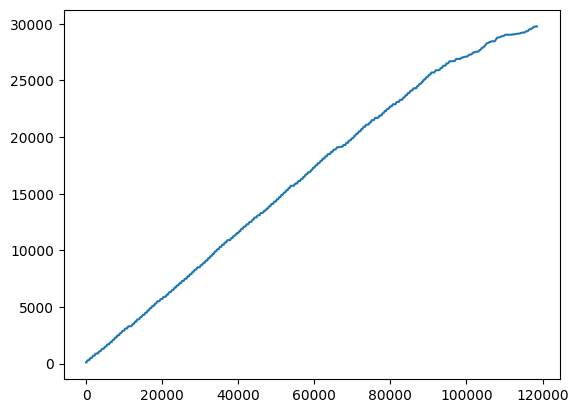

In [27]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']
bin_config = get_bin_config(session_type)['P']

bin_size_cm = 2
positions = np.array(session['P'])
times = np.array(session['P'].index)
trial_numbers = np.array(session['trial_number'])
distance_travelled = positions+(tl*(trial_numbers-1))
distance_travelled_adjusted = distance_travelled-((trial_numbers[0]-1)*tl)
n_bins = int(int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)/bin_size_cm)
max_bound = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)
min_bound = 0
tmp_TSD = nap.TsdFrame(t=times, d=distance_travelled_adjusted, columns=['dt'])


print(f'first position: {positions[0]}')
print(f'this mouse started on trial number {int(np.min(trial_numbers))}')
print(f'this mouse ended on trial number {int(np.max(trial_numbers))}')
print(f'this completed experienced {np.max(trial_numbers)-np.min(trial_numbers)+1} trials')
print(f'each trial equates to {tl} cm')
print(f'this mouse travelled {np.nanmax(distance_travelled_adjusted)/100} meters')
print(f'we will use a bin size of {bin_size_cm} cm and {n_bins} bins')
plt.plot(distance_travelled_adjusted)
plt.show()



In [28]:
tcs = {}
for index in neurons.index:
    this_neuron = neurons[neurons.index == index]
    tc = nap.compute_1d_tuning_curves(this_neuron, 
                                      tmp_TSD["dt"], 
                                      nb_bins=n_bins, 
                                      minmax=[min_bound, max_bound])[index]
    mask = np.isnan(tc)
    tc = gaussian_filter(np.nan_to_num(tc).astype(np.float64), sigma=bin_config['smooth_sigma'])
    tcs[index] = tc

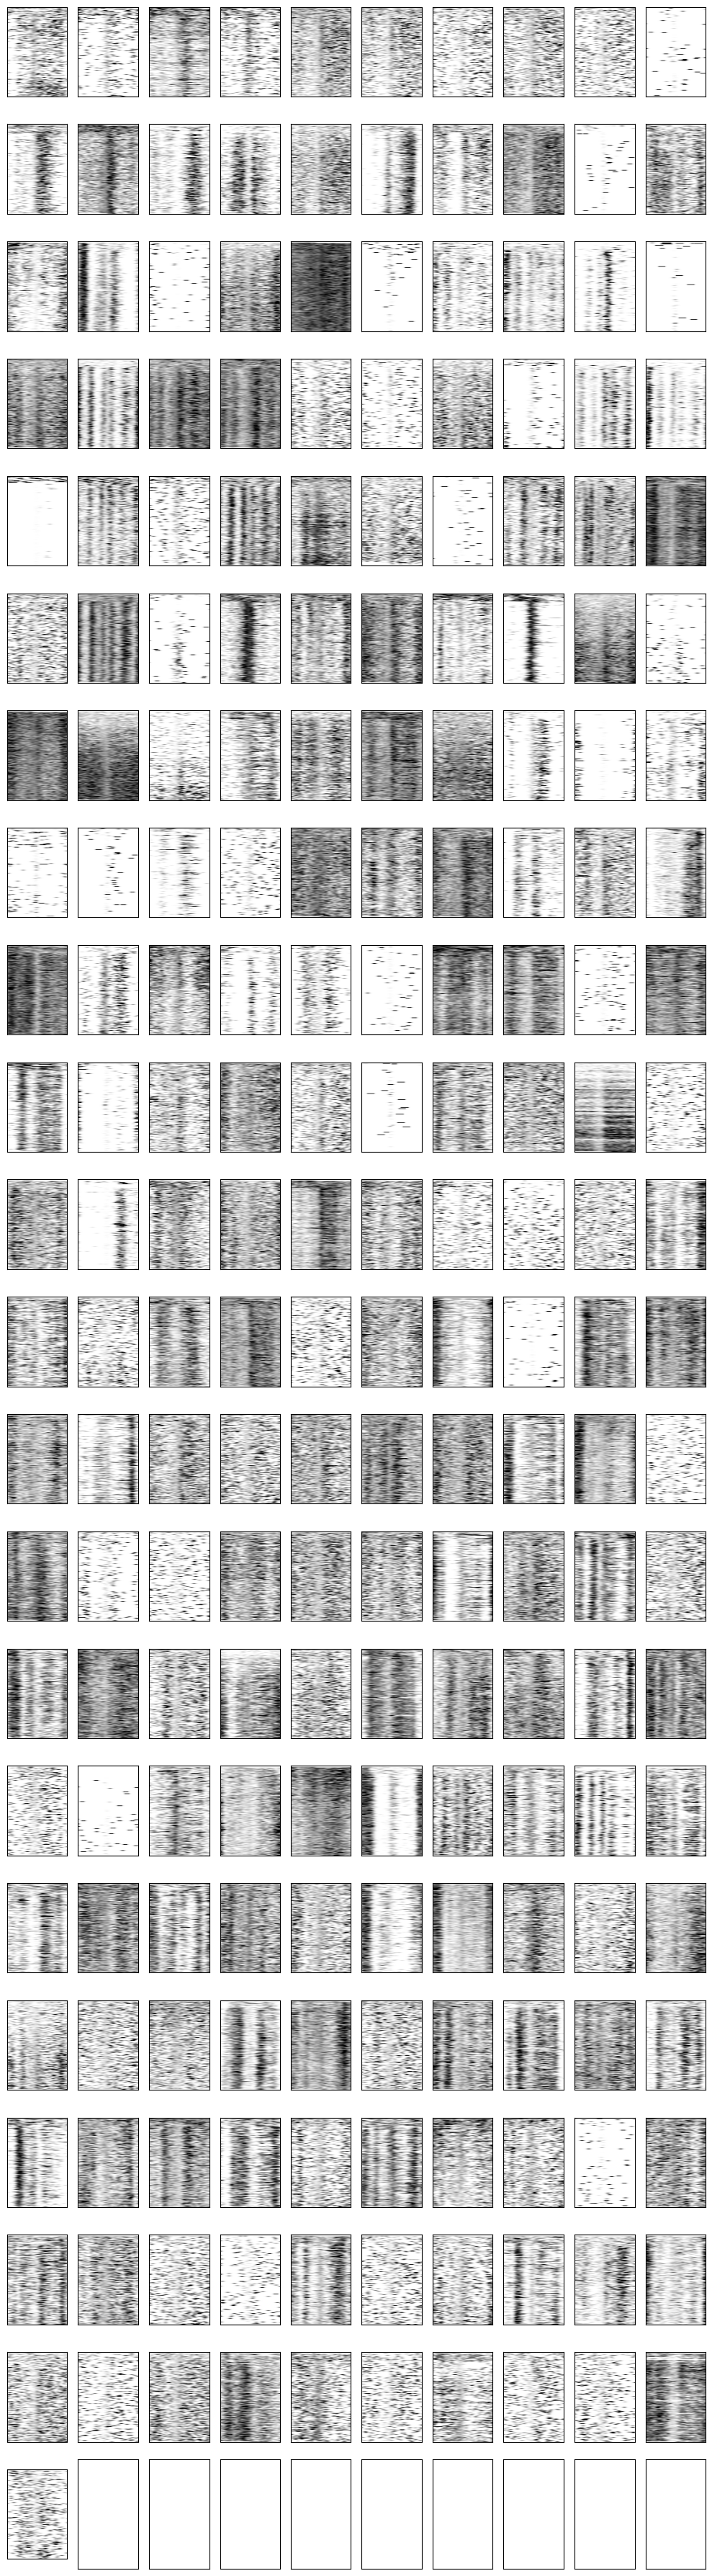

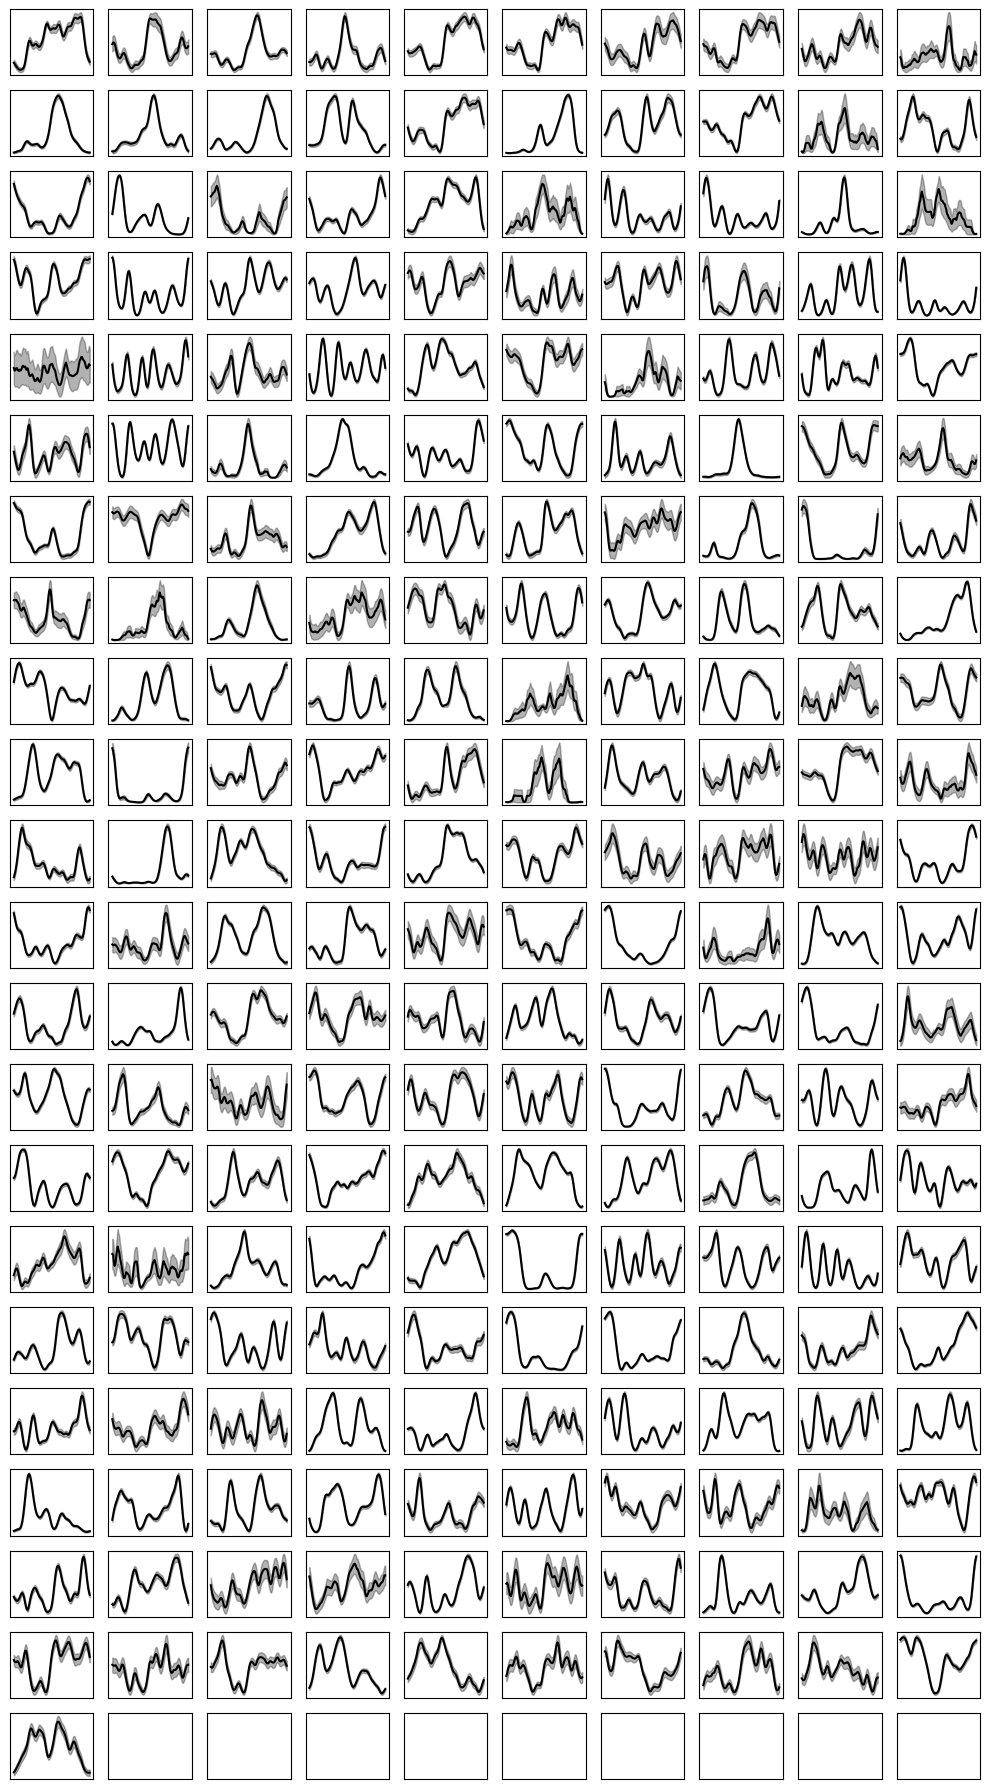

In [29]:
# Plot
ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 4*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = neurons.index[counter]
            plot_firing_rate_map(ax[j, i], 
                                    zscore(tcs[index]),
                                    bs=bin_size_cm,
                                    tl=tl)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()


ncols = 10
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 2*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            index = neurons.index[counter]
            plot_avg_firing_rate_map(ax[j, i], 
                                        zscore(tcs[index]), 
                                        bs=bin_size_cm,
                                        tl=tl)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()
